In [1]:
import os
if not os.path.exists('cell_images'):
    !pip install -U -q torch_snippets
    !wget -q ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
    !unzip -qq cell_images.zip
    !rm cell_images.zip
from torch_snippets import *

     |████████████████████████████████| 204kB 6.3MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 


2021-06-09 09:51:05.650 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-06-09 09:51:06.327 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [2]:
#indices correspondimg to the output classes
id2int = {'Parasitized':0 , 'Uninfected':1}

##  transformation on train images

In [3]:
from torchvision import transforms as T

trn_tfms = T.Compose([
                      T.ToPILImage(),
                      T.Resize(128),
                      T.CenterCrop(128),
                      T.ColorJitter(brightness=(0.95,1.05),
                                    contrast=(0.95,1.05),
                                    saturation=(0.95,1.05),
                                    hue=0.05),
                      T.RandomAffine(5,translate=(0.01,0.1)),
                      T.ToTensor(), #Scaling an image using the ToTensor method to have a value between 0 and 1...
                      T.Normalize(mean=[0.5,0.5,0.5],
                                  std=[0.5,0.5,0.5]),
])

transformation on val_images

In [4]:
val_tfms = T.Compose([
                      T.ToPILImage(),
                      T.Resize(128),
                      T.CenterCrop(128),
                      T.ToTensor(),
                      T.Normalize(mean=[0.5,0.5,0.5],
                                  std=[0.5,0.5,0.5]),
])

## Dataset class 

In [5]:
class MalariaImages(Dataset):
    def __init__(self,files,transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return  len(self.files)

    def __getitem__(self,ix):
        fpath = self.files[ix]
        clss =  fname(parent(fpath))
        img =read(fpath,1)
        return img,clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self,batch):
        _imgs,classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None]for img in _imgs]
        classes = [torch.tensor([id2int[clss]])for clss in classes]
        imgs,classes = [torch.cat(i).to(device) for i in [imgs,classes]]
        return imgs,classes,_imgs

## training and validation dataset  and dataloader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import  train_test_split
trn_files,val_files = train_test_split(all_files,random_state=1)

trn_ds = MalariaImages(trn_files,transform=trn_tfms)
val_ds = MalariaImages(val_files,transform=val_tfms)

trn_dl = DataLoader(trn_ds,batch_size=32,shuffle=True,collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds,batch_size=32,shuffle=False,collate_fn=val_ds.collate_fn)

2021-06-09 09:51:06.495 | INFO     | __main__:<module>:2 - 27558 files found at cell_images/*/*.png
2021-06-09 09:51:06.510 | INFO     | __main__:__init__:5 - 20668
2021-06-09 09:51:06.511 | INFO     | __main__:__init__:5 - 6890


In [7]:
# Define the model Malaria Classifier..

def convBlock(ni,no):
    return nn.Sequential(
        nn.Dropout(0.4),
        nn.Conv2d(ni,no,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )
class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3,64),
            convBlock(64,64),
            convBlock(64,128),
            convBlock(128,256),
            convBlock(256,512),
            convBlock(512,64),
            nn.Flatten(),
            nn.Linear(256,256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256,len(id2int))

        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self,x):
        return self.model(x)

    def compute_metrics(self,preds,targets):
        loss = self.loss_fn(preds,targets)
        acc = (torch.max(preds,1)[1]==targets).float().mean()
        return loss,acc

In [8]:
#Define the functions to train and validate on a batch of data:
def train_batch(model,data,optimizer,criterion):
    model.train()
    ims,labels, _ =data
    _preds = model(ims)
    optimizer.zero_grad()
    loss,acc = criterion(_preds,labels)
    loss.backward()
    optimizer.step()
    return loss.item(),acc.item()

@torch.no_grad()
def validate_batch(model,data,criterion):
    model.eval()
    ims,labels , _ = data
    _preds = model(ims)
    loss,acc = criterion(_preds,labels)
    return loss.item(),acc.item()

## Train the model over increasing epochs

In [9]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(),lr=1e-3)
n_epochs =2


log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx,data in enumerate(trn_dl):
        loss,acc = train_batch(model,data,optimizer,criterion)
        log.record(ex+(bx+1)/N,trn_loss=loss,val_acc=acc,end ='\r')
    log.report_avgs(ex+1)


EPOCH: 1.000	trn_loss: 0.309	val_acc: 0.865	(97.22s - 97.22s remaining)
EPOCH: 2.000	trn_loss: 0.181	val_acc: 0.941	(193.62s - 0.00s remaining)


In [10]:
#Fetch the convolution layer in the fifth convBlock in the model:
im2fmap = nn.Sequential(*(list(model.model[:5].children())+list(model.model[5][:2].children())))

## **im2gradCAM**

In [21]:
#it takes an input image and fetches the heatmap corresponding to activations of the image:
def img2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps= []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model prediction
    model.zero_grad()
    #Compute gradients with respect to model most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required feature map location
    # and take the avg gradient for every feature map
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # Multiply each activation map with coresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:]*=pooled_grads[i]
    # take the mean of all weighted activation maps
    # that has been weighted by avg. grad at each fmap
    heatmap = torch.mean(activations,dim=1)[0].cpu().detach()
    return heatmap,'Uninfected' if pred.item() else 'Parasitized'



In [22]:
#Define the upsampleHeatmap function to up-sample the heatmap to a shape that corresponds to the shape of the image:
SZ = 128
def upsampleHeatmap(map,img):
    m,M = map.min(), map.max()
    map = 255*((map-m)/(M-m))
    map = np.uint8(map)
    map = cv2.resize(map,(SZ,SZ))
    map = cv2.applyColorMap(255-map,cv2.COLORMAP_JET)
    map = np.uint8(map*0.7 + img*0.3)
    return map
    #In the preceding lines of code, we are de-normalizing the image and also overlaying the heatmap on top of the image.

# A set of images

torch.Size([1, 64, 4, 4])

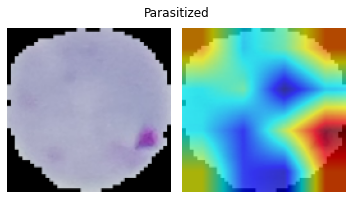

torch.Size([1, 64, 4, 4])

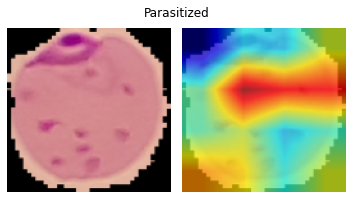

torch.Size([1, 64, 4, 4])

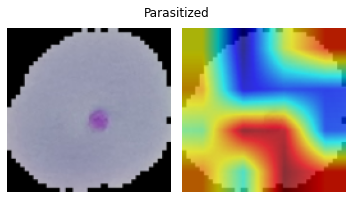

torch.Size([1, 64, 4, 4])

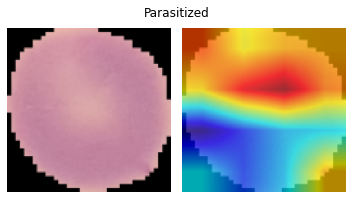

torch.Size([1, 64, 4, 4])

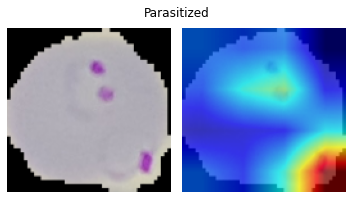

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

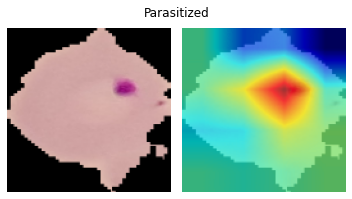

torch.Size([1, 64, 4, 4])

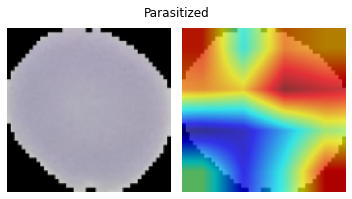

torch.Size([1, 64, 4, 4])

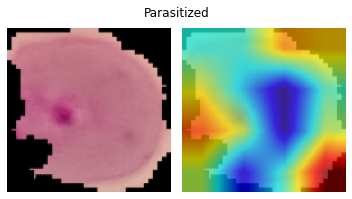

torch.Size([1, 64, 4, 4])

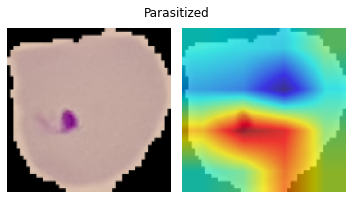

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

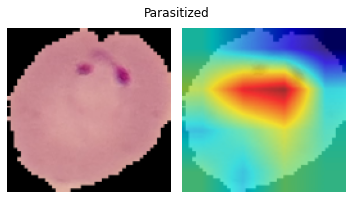

torch.Size([1, 64, 4, 4])

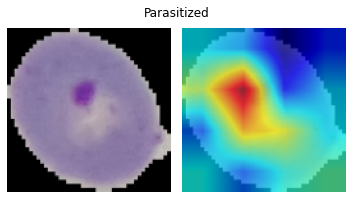

torch.Size([1, 64, 4, 4])

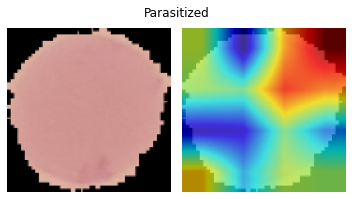

torch.Size([1, 64, 4, 4])

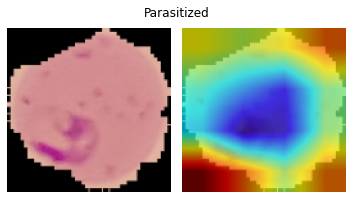

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

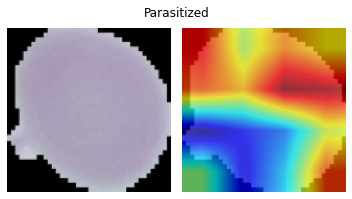

torch.Size([1, 64, 4, 4])

torch.Size([1, 64, 4, 4])

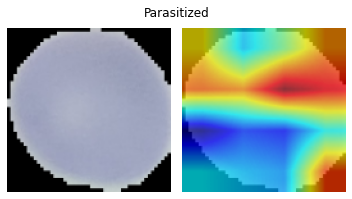

torch.Size([1, 64, 4, 4])

In [24]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = img2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)

From this, we can see that the prediction is as it is because of the content that is highlighted in red (which has the highest CAM value).